In [1]:
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from copy import deepcopy
import datetime
import pytz

# Load Dataset

In [2]:
sat_data = pd.read_csv("no2_dataset.csv", parse_dates=["SatelliteDatetime", "SurfaceDatetime"])
sat_data = gpd.GeoDataFrame(sat_data, geometry=gpd.points_from_xy(sat_data.SurfaceLongitude, sat_data.SurfaceLatitude))

# Air Quality Station Locations

In [3]:
locations = sat_data[["SurfaceLongitude", "SurfaceLatitude"]].drop_duplicates()

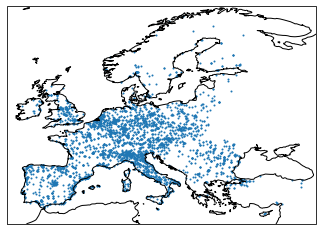

In [4]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

plt.scatter(locations.SurfaceLongitude, locations.SurfaceLatitude, s=1)

plt.show()

# NO$_2$ Timeseries

In [5]:
country = "ES"
types = ["traffic", "background", "industrial"]
date_start = datetime.datetime(2019, 1, 1,0,0,0,0, pytz.FixedOffset(60))
date_end = datetime.datetime(2020, 12, 31,23,59,59,0, pytz.FixedOffset(60))

main_frequency = "14D"
background_frequency = "1D"

colors = {"traffic" : "brown", "industrial" : "blue", "background" : "green", "lockdown" : "grey", "reference" : "lightgrey"}

In [6]:
data = {station_type : sat_data.loc[(sat_data.Countrycode == country) & (sat_data.StationType == station_type) & 
                              (sat_data.SurfaceDatetime >= date_start) & (sat_data.SurfaceDatetime <= date_end), :].copy() 
             for station_type in types}
data = {station_type : [df, df.copy()] for station_type, df in data.items()}

In [7]:
for station_type, (main_data, background_data) in data.items():
    main_data.set_index("SurfaceDatetime", inplace=True)
    main_data.sort_values(by="SurfaceDatetime", inplace=True)
    data[station_type][0] = main_data.resample(main_frequency).mean()
    
    background_data.set_index("SurfaceDatetime", inplace=True)
    background_data.sort_values(by="SurfaceDatetime", inplace=True)
    data[station_type][1] = background_data.resample(background_frequency).mean()

In [8]:
data_lockdowns = sat_data.loc[sat_data.Countrycode == country, ["SurfaceDatetime", "Lockdown"]].copy()
data_lockdowns.set_index("SurfaceDatetime", inplace=True)
data_lockdowns = data_lockdowns.resample("1D").agg(pd.Series.mode)
lockdown_times = data_lockdowns[data_lockdowns.Lockdown == "StayHomeOrder"].index

lockdown_start = lockdown_times.min()
lockdown_end = lockdown_times.max()

one_year = datetime.timedelta(days=365)
reference_start = lockdown_start - one_year
reference_end = lockdown_end - one_year

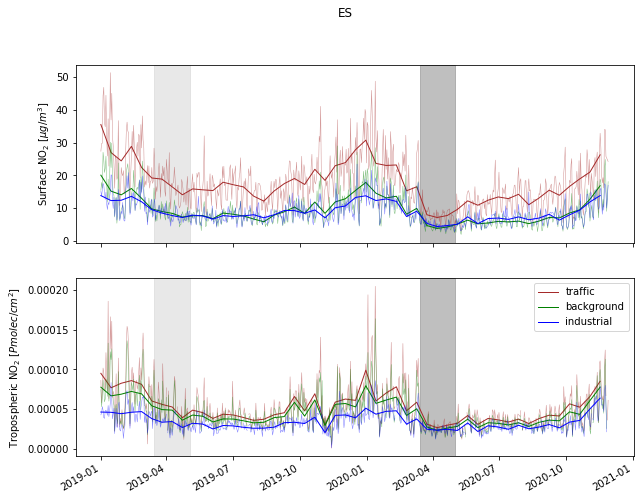

In [9]:
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(10, 8))

for station_type, (main_data, background_data) in data.items():
    color = colors.get(station_type)
    ax_top.plot(main_data.index[main_data.SurfaceConcentration < 80], main_data.SurfaceConcentration[main_data.SurfaceConcentration < 80], label=f"{station_type}", alpha=1, linewidth=1, c=color)
    ax_bottom.plot(main_data.index, main_data.TroposphericNO2ColumnNumberDensity, label=f"{station_type}", alpha=1, linewidth=1, c=color)
    
    ax_top.plot(background_data[background_data.SurfaceConcentration < 80].index, background_data[background_data.SurfaceConcentration < 80].SurfaceConcentration, alpha=0.5, linewidth=0.5, c=color)
    ax_bottom.plot(background_data.index, background_data.TroposphericNO2ColumnNumberDensity, alpha=0.5, linewidth=0.5, c=color)
    

ax_top.axvspan(lockdown_start, lockdown_end, alpha=0.5, color=colors.get("lockdown"))
ax_bottom.axvspan(lockdown_start, lockdown_end, alpha=0.5, color=colors.get("lockdown"))

ax_top.axvspan(reference_start, reference_end, alpha=0.5, color=colors.get("reference"))
ax_bottom.axvspan(reference_start, reference_end, alpha=0.5, color=colors.get("reference"))

ax_top.set_ylabel("Surface NO$_2$ $[\mu g/m^3]$")
ax_bottom.set_ylabel("Tropospheric NO$_2$ $[Pmolec/cm^2]$")


ax_bottom.legend()

fig.autofmt_xdate()
plt.suptitle(country)
plt.show()